In [1]:
# Modules to ignore warnings
import warnings               
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import os   
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import call

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
train_path = '/content/drive/My Drive/Colab Notebooks/10_categories'   # Train data path
classes = os.listdir(train_path)                          # List of directories in train path
print(classes)

['car_side', 'watch', 'Faces_easy', 'airplanes', 'Leopards', 'Motorbikes', 'BACKGROUND_Google', 'Faces', 'bonsai', 'grand_piano']


In [5]:
for ix,i in enumerate(classes):
    print(i,"\n",len(os.listdir(os.path.join(train_path,i))))

car_side 
 712
watch 
 823
Faces_easy 
 731
airplanes 
 828
Leopards 
 775
Motorbikes 
 798
BACKGROUND_Google 
 759
Faces 
 730
bonsai 
 708
grand_piano 
 689


In [8]:
# This is the augmentation configuration we will use for training
data_generator = ImageDataGenerator(rescale=1/255.,
                                    rotation_range=20,
                                    height_shift_range=0.2,
                                    validation_split = 0.3,
                                    zoom_range=0.2)

# This is a generator that will read pictures found in subfolers of 'train', and generates
# batches of augmented image data on the fly
train_generator = data_generator.flow_from_directory(directory=train_path,
                                                   # batch_size=64, 
                                                    class_mode='categorical', 
                                                    shuffle=True,
                                                    subset = "training",
                                                    target_size=(224 ,224))

val_generator = data_generator.flow_from_directory(directory=train_path,
                                                   # batch_size=64,
                                                    class_mode='categorical', 
                                                    shuffle=True,
                                                    subset = "validation",
                                                    target_size=(224 ,224))

Found 6046 images belonging to 10 classes.
Found 1506 images belonging to 10 classes.


In [3]:
from keras.applications.mobilenet_v2 import MobileNetV2

def model_tl(nb_classes, freez_wts):
    
    trained_model = MobileNetV2(include_top=False, weights='imagenet',input_shape = (224, 224, 3))
    x = trained_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    pred_inception= Dense(nb_classes,activation='softmax')(x)
    model = Model(inputs=trained_model.input,outputs=pred_inception)
    
    for layer in trained_model.layers:
        layer.trainable=(1-freez_wts)
    
    return(model)
  

In [7]:
model = model_tl(nb_classes=10, freez_wts=False)
 
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='Adadelta')

9412608/9406464 [==============================] - 22s 2us/step


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

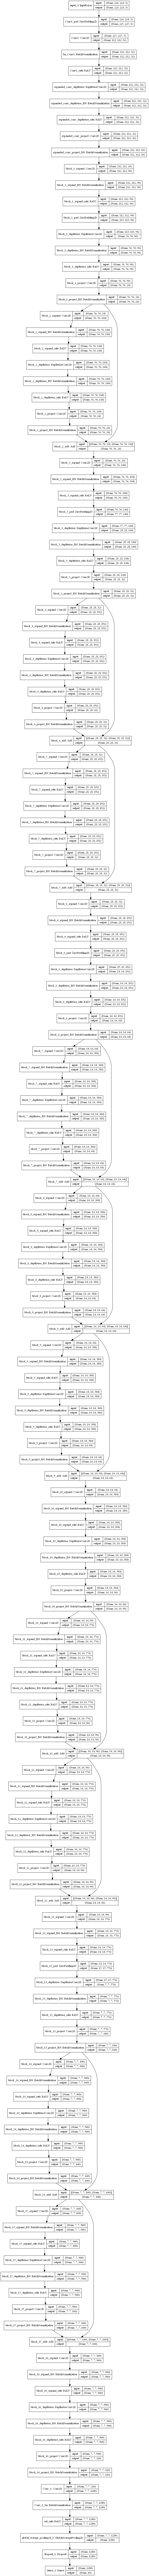

In [9]:
from keras.utils import plot_model
plot_model(model, to_file='MobileNetV2.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image("MobileNetV2.png")

In [16]:
chkp = ModelCheckpoint(filepath='MobileNetV2_tl.h5', monitor='val_acc', save_best_only=True, save_weights_only=False, verbose=0)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = train_generator.samples/train_generator.batch_size,
                              
                              validation_data = val_generator, 
                              validation_steps = val_generator.samples/val_generator.batch_size,
                              callbacks= [chkp],
                              epochs=50, verbose= 1 ,shuffle = True).history

Epoch 1/50
189/188 [==============================] - 2048s 11s/step - loss: 0.2440 - acc: 0.9272 - val_loss: 0.5232 - val_acc: 0.9064
Epoch 2/50
189/188 [==============================] - 135s 714ms/step - loss: 0.1348 - acc: 0.9648 - val_loss: 2.7201 - val_acc: 0.6534
Epoch 3/50
189/188 [==============================] - 138s 730ms/step - loss: 0.1058 - acc: 0.9704 - val_loss: 2.1763 - val_acc: 0.7377
Epoch 4/50
189/188 [==============================] - 137s 725ms/step - loss: 0.0648 - acc: 0.9815 - val_loss: 0.7205 - val_acc: 0.8831
Epoch 5/50
189/188 [==============================] - 137s 726ms/step - loss: 0.0764 - acc: 0.9795 - val_loss: 1.2289 - val_acc: 0.8367
Epoch 6/50
189/188 [==============================] - 138s 731ms/step - loss: 0.0469 - acc: 0.9853 - val_loss: 1.0991 - val_acc: 0.8313
Epoch 7/50
189/188 [==============================] - 137s 727ms/step - loss: 0.0471 - acc: 0.9866 - val_loss: 1.7319 - val_acc: 0.7689
Epoch 8/50
189/188 [=============================

In [17]:
max(history['val_acc'])

0.9920318725099602

Text(0.5, 1.0, 'Accuracy')

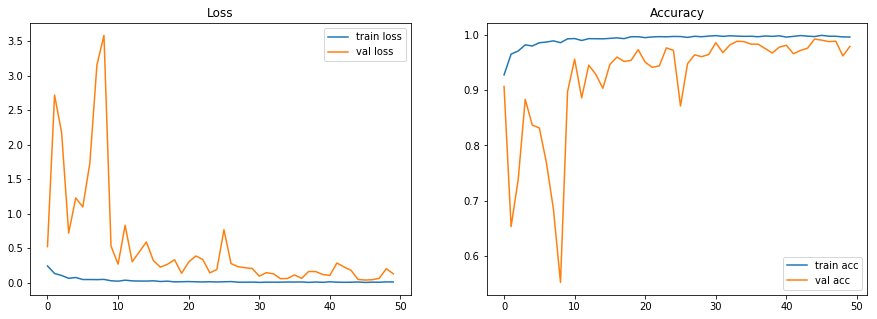

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
train_loss = plt.plot(history['loss'], label='train loss')
val_loss = plt.plot(history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
train_loss = plt.plot(history['acc'], label='train acc')
val_loss = plt.plot(history['val_acc'], label='val acc')
plt.legend()
plt.title('Accuracy')

In [27]:
chkp.params

{'do_validation': True,
 'epochs': 50,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'],
 'steps': 188.9375,
 'verbose': 1}

In [45]:
chkp.params.values()

dict_values([50, 188.9375, 1, True, ['loss', 'acc', 'val_loss', 'val_acc']])

In [66]:
chkp.filepath.

AttributeError: ignored